In [1]:
import os
import h5py
import numpy as np 

In [2]:
from provabgs import util as UT
from provabgs import models as Models
from speclite import filters as specFilter

/Users/chahah/projects/provabgs/src/provabgs/models.py:29: UserWarning: import error with pytorch; cannot use msurv emulator
  warnings.warn('import error with pytorch; cannot use msurv emulator')


In [3]:
# make pretty plots
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [5]:
hpix = h5py.File('/Users/chahah/data/provabgs/provabgs-sv3-bright-26961.BGS_BRIGHT.hdf5', 'r')

In [6]:
mcmc = UT.flatten_chain(hpix['samples'][...][4,:,:,:])
zred = hpix['redshift'][...][4]

In [7]:
logMs = hpix['logMstar'][...][4]

In [8]:
sfr_1gyr = m_nmf.avgSFR(mcmc[:,:-1], zred=zred, dt=1)

In [9]:
Z_mw = m_nmf.Z_MW(mcmc[:,:-1], zred=zred)

In [10]:
tage = m_nmf.tage_MW(mcmc[:,:-1], zred=zred)

In [11]:
posterior = np.vstack([logMs, np.log10(sfr_1gyr), np.log10(Z_mw), tage]).T

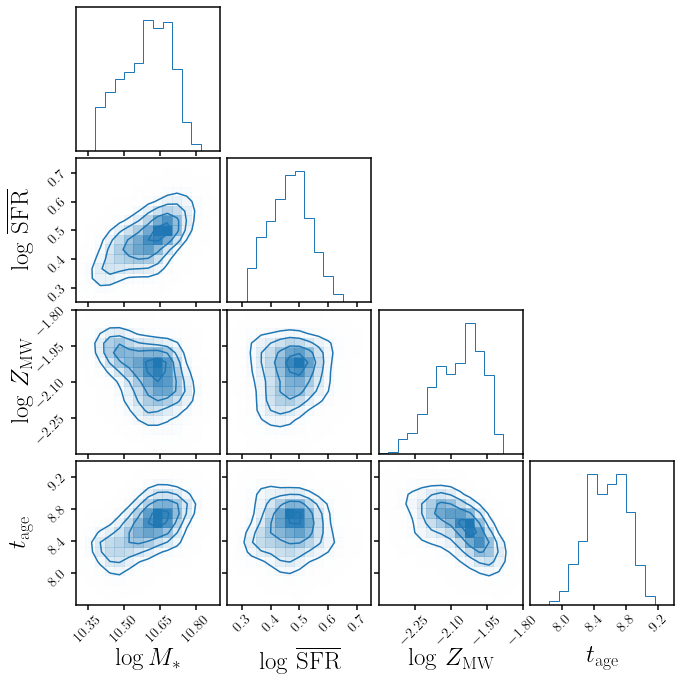

In [12]:
fig = DFM.corner(posterior[-5000:], 
                 range=[(10.3, 10.9), (0.25, 0.75), (-2.4, -1.8), (7.6, 9.4)],
                 labels=[r'$\log M_*$', r'$\log$ $\overline{\rm SFR}$', r'$\log$ $Z_{\rm MW}$', r'$t_{\rm age}$'],
                 label_kwargs={'fontsize': 25},
                 color='C0', bins=15, smooth=True, plot_datapoints=False)

In [13]:
desi_bands = specFilter.load_filters(*tuple(['decam2014-g', 'decam2014-r', 'decam2014-z']))

In [14]:
1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472])

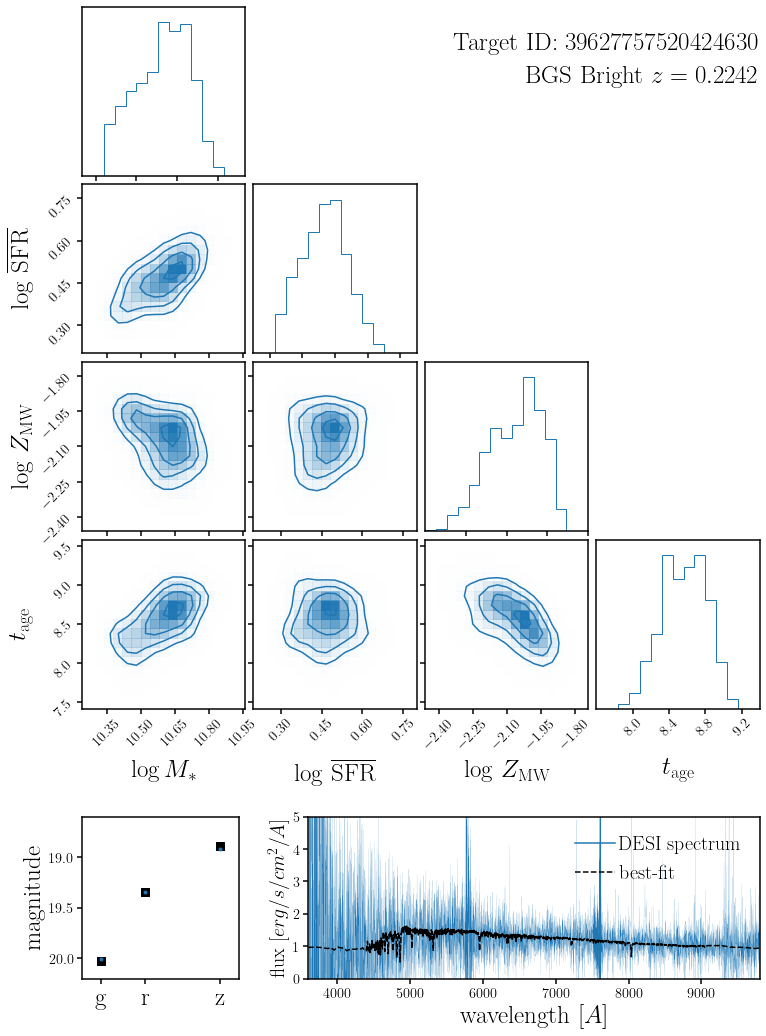

In [17]:
ndim = 4
fig = plt.figure(figsize=(11, 15))
gs0 = fig.add_gridspec(nrows=ndim, ncols=ndim, top=0.95, bottom=0.3)
for yi in range(ndim):
    for xi in range(ndim):
        sub = fig.add_subplot(gs0[yi, xi])

_fig = DFM.corner(posterior[-5000:], 
             range=[(10.3, 10.9), (0.25, 0.75), (-2.4, -1.8), (7.6, 9.4)],
             labels=[r'$\log M_*$', r'$\log$ $\overline{\rm SFR}$', r'$\log$ $Z_{\rm MW}$', r'$t_{\rm age}$'],
             label_kwargs={'fontsize': 25},
             color='C0', bins=15, smooth=True, plot_datapoints=False, fig=fig)

axes = np.array(_fig.axes).reshape((ndim, ndim))
ax = axes[0, 3]
ax.text(1, 4.0, 'Target ID: %i' % hpix['targetid'][4], ha='right', va='top', transform=sub.transAxes, fontsize=25)
ax.text(1, 3.7, 'BGS Bright $z = %.4f$' % hpix['redshift'][4], ha='right', transform=sub.transAxes, fontsize=25)

gs1 = fig.add_gridspec(nrows=1, ncols=30, top=0.2, bottom=0.05)
sub = fig.add_subplot(gs1[0, :7])

mags = 22.5 - 2.5 * np.log10(hpix['flux_photo_obs'][4])
mags_err = np.abs(-2.5 * hpix['ivar_photo_obs'][4]**-0.5 / hpix['flux_photo_obs'][4] / np.log(10))
sub.errorbar([4720., 6415., 9260.], mags, yerr=mags_err, fmt='.C0')

mags_model = 22.5 - 2.5 * np.log10(m_nmf.sed(hpix['theta_bf'][4][:-1], hpix['redshift'][4], filters=desi_bands)[-1])
sub.scatter([4720., 6415., 9260.], mags_model, marker='s', facecolor='none', s=70, c='k')
sub.set_xlim(4000, 1e4)
sub.set_xticks([4720., 6415., 9260])
sub.set_xticklabels(['g', 'r', 'z'], fontsize=25)
sub.set_ylabel('magnitude', fontsize=25)
sub.set_ylim(20.2, 18.6)

sub = fig.add_subplot(gs1[0, 10:])
sub.plot(hpix['wavelength_obs'][4], hpix['flux_spec_obs'][4], c='C0', lw=0.1)
sub.plot([], [], c='C0', label='DESI spectrum')
sub.plot(hpix['wavelength_obs'][4], hpix['flux_spec_model'][4], c='k', ls='--', label='best-fit', rasterized=True)

sub.legend(loc='upper right', fontsize=20, handletextpad=0.2)
sub.set_xlabel('wavelength [$A$]', fontsize=25) 
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(0., 5)
sub.set_ylabel('flux [$erg/s/cm^2/A$]', fontsize=20) 

    
fig.savefig('../figs/provabgs_posterior.pdf', bbox_inches='tight') 